# CLASSIFICATION

## Import

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


#from sklearn
from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score, precision_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [72]:
df = pd.read_csv("./data/wikiArticles_preprocessed.csv", index_col='title').drop(['Unnamed: 0','length','pageid'], axis=1)

In [73]:
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(df.category)
df.category = label_encoder.transform(df.category) #softeng -> 0, sports -> 1

In [74]:
df.iloc[[0,-1]] #first and last element

,content,category
title,,
acceptance testing,engineering various subdisciplines acceptance ...,0
sports before 1001,article present chronology sport development e...,1


## Classification using TFIDF

Let's start to build our classifiers using the TFIDF matrix.

In [75]:
X_tfidf = np.array(np.load("./data/tfidf_mat.npy")).astype(float)

In [76]:
y = df.category.values

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.1, random_state=11)

In [78]:
pd.DataFrame(y_test)[0].value_counts()

1    100
0    100
Name: 0, dtype: int64

We have now 100 articles of each category in the test set and 900 articles in the train set.

### Standardization

In [79]:
X_train_std = (X_train-X_train.mean()) / X_train.std()
X_test_std = (X_test-X_train.mean()) / X_train.std()

### Score metrics
Since our dataset is totally balanced we could use simple score metrics such as `accuracy` but for our classifiers let's use the `f1-score`  from `sklearn.metrics` which is the harmonic mean of precision and recall.

## Naive Bayes

To get a baseline for our task, let's start with a very well known classifier for text classification: Naïve Bayes classifier.

In [12]:
nb_clf = MultinomialNB()
nb_clf.fit(X_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [48]:
pred_nb = nb_clf.predict(X_test)
print("Confusion matrix : \n", confusion_matrix(y_test,pred_nb))
print("F1-score : ", f1_score(y_test,pred_nb))


Confusion matrix : 
 [[97  3]
 [ 1 99]]
F1 score :  0.980198019802


We can see that the performance is already excellent. From our pca plot we could indeed except these kind of result.

## Logistic Regression

Let's try now with a logistic regression which is more suited for larger sample size dataset, but it is nice to see its performance. 

In [35]:
log_clf = LogisticRegression(C=1,max_iter = 200, class_weight='balanced')
log_clf.fit(X_train,y_train)

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=200,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [47]:
pred_log = log_clf.predict(X_test)
print("Confusion matrix : \n", confusion_matrix(y_test,pred_nb))
print("F1-score : ", f1_score(y_test,pred_nb))

Confusion matrix : 
 [[97  3]
 [ 1 99]]
F1 score :  0.980198019802


### Cross Validation

The result could seem to be too good to be true, so let's check if we are overfitting and verify our performance.

In [50]:
k_fold = KFold(n_splits=10) 
#to keep the proportion trainset-testset, we choose a 10-folds CV : training on 9 folds and validate on 1 fold.

In [51]:
logreg_cv = [log_clf.fit(X_train[train], y_train[train]) for train, test in k_fold.split(X_train)]

In [65]:
lst_f1 =[]
for idx, model in enumerate(logreg_cv):
    pred = model.predict(X_test)
    lst_f1.append(f1_score(y_test, pred))

print('mean f1-score: ' + str(np.mean(lst_f1)))
print('variance score: ' + str(np.var(lst_f1)))


mean f1-score: 0.980392156863
variance score: 1.23259516441e-32


We can see that our classifier looks very correct and stable as well. 

#### With standardized dataset

In [64]:
log_clf_std = LogisticRegression(C=1,max_iter = 200, class_weight='balanced')
logreg_cv_std = [log_clf_std.fit(X_train_std[train], y_train[train]) for train, test in k_fold.split(X_train_std)]

In [66]:
lst_f1_std =[]
for idx, model in enumerate(logreg_cv_std):
    pred_std = model.predict(X_test_std)
    lst_f1_std.append(f1_score(y_test, pred_std))

print('mean f1-score: ' + str(np.mean(lst_f1_std)))
print('variance score: ' + str(np.var(lst_f1_std)))


mean f1-score: 0.985221674877
variance score: 0.0


With the LogReg, the standardized features don't change much in the result.

## Support Vector Classification

In [67]:
svc_clf = SVC()
svc_clf.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [68]:
pred_svc = svc_clf.predict(X_test)
print("Confusion matrix : \n", confusion_matrix(y_test,pred_svc))
print("F1-score : ", f1_score(y_test,pred_svc))

Confusion matrix : 
 [[78 22]
 [ 2 98]]
F1-score :  0.890909090909


#### With Standardized features

In [69]:
svc_clf_std = SVC()
svc_clf_std.fit(X_train_std,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [70]:
pred_svc_std = svc_clf_std.predict(X_test_std)
print("Confusion matrix : \n", confusion_matrix(y_test,pred_svc_std))
print("F1-score : ", f1_score(y_test,pred_svc_std))

Confusion matrix : 
 [[ 96   4]
 [  0 100]]
F1-score :  0.980392156863


Here we can see that the standardized features improve the performance.

### Grid search for best params

In [90]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001]}

In [91]:
grid = GridSearchCV(SVC(),param_grid, refit=True, verbose=2) 
grid.fit(X_train_std,y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] C=0.1, gamma=1 ..................................................
[CV] ................................... C=0.1, gamma=1, total= 2.3min
[CV] C=0.1, gamma=1 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.8min remaining:    0.0s


[CV] ................................... C=0.1, gamma=1, total= 2.3min
[CV] C=0.1, gamma=1 ..................................................
[CV] ................................... C=0.1, gamma=1, total= 2.3min
[CV] C=0.1, gamma=0.1 ................................................
[CV] ................................. C=0.1, gamma=0.1, total= 2.3min
[CV] C=0.1, gamma=0.1 ................................................
[CV] ................................. C=0.1, gamma=0.1, total= 2.3min
[CV] C=0.1, gamma=0.1 ................................................
[CV] ................................. C=0.1, gamma=0.1, total= 2.3min
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ................................ C=0.1, gamma=0.01, total= 2.3min
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ................................ C=0.1, gamma=0.01, total= 2.3min
[CV] C=0.1, gamma=0.01 ...............................................
[CV] .

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed: 218.9min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=2)

In [92]:
grid.best_params_

{'C': 0.1, 'gamma': 0.001}

### Classification result using the `best_params_`

In [93]:
pred_grid = grid.predict(X_test_std)
print("Confusion matrix : \n", confusion_matrix(y_test,pred_grid))
print("F1-score : ", f1_score(y_test,pred_grid))

Confusion matrix : 
 [[97  3]
 [ 7 93]]
F1-score :  0.948979591837


score moin bien mais cv montre que pas overfit

## KNN Classification

In [85]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [86]:
pred_knn = knn.predict(X_test)
print("Confusion matrix : \n", confusion_matrix(y_test,pred_knn))
print("F1-score : ", f1_score(y_test,pred_knn))

Confusion matrix : 
 [[97  3]
 [ 5 95]]
F1-score :  0.959595959596


#### With Standardized features

In [83]:
knn_std = KNeighborsClassifier(n_neighbors=3)
knn_std.fit(X_train_std,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [84]:
pred_knn_std = knn_std.predict(X_test_std)
print("Confusion matrix : \n", confusion_matrix(y_test,pred_knn_std))
print("F1-score : ", f1_score(y_test,pred_knn_std))

Confusion matrix : 
 [[97  3]
 [ 5 95]]
F1-score :  0.959595959596


Here again the standardize features don't influence the performance a lot. For algortihms that use distance measurements, normalization or scaling could be a better solution. 

#### With Normalized features

In [12]:
normalizer = Normalizer().fit(X_train)

In [13]:
X_train_nrm = normalizer.transform(X_train)
X_test_nrm = normalizer.transform(X_test)

In [82]:
knn_nrm = KNeighborsClassifier(n_neighbors=3)
knn_nrm.fit(X_train_nrm,y_train)
pred_knn_nrm = knn_nrm.predict(X_test_nrm)
print("Confusion matrix : \n", confusion_matrix(y_test,pred_knn_nrm))
print("F1-score : ", f1_score(y_test,pred_knn_nrm))

Confusion matrix : 
 [[97  3]
 [ 5 95]]
F1-score :  0.959595959596


We don't see any difference and this may be due by the fact that the simplicity of our task makes difficult to realize the implication of standardization or normalization. 

### Choosing K Value

In [87]:
error_rate = []

for i in range(1,40):
    
    knn_nrm = KNeighborsClassifier(n_neighbors=i)
    knn_nrm.fit(X_train_nrm,y_train)
    pred_i = knn_nrm.predict(X_test_nrm)
    error_rate.append(np.mean(pred_i != y_test))

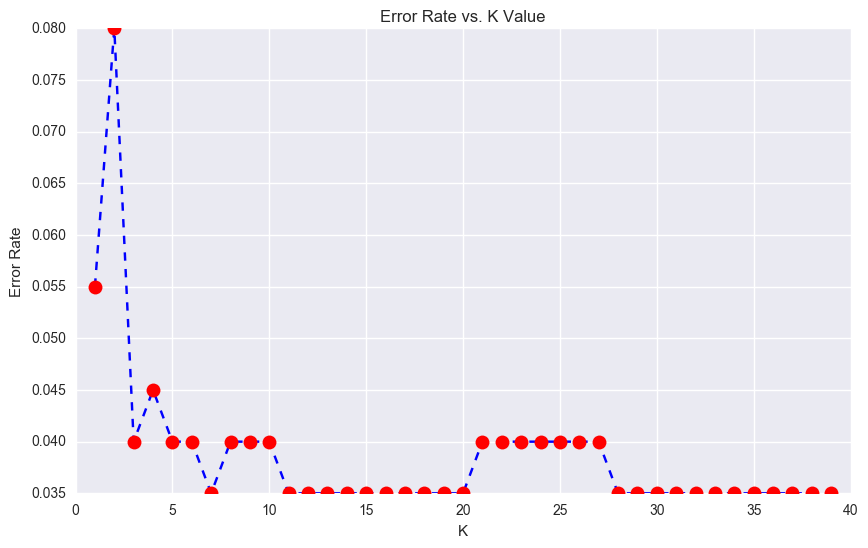

In [88]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

### Classification result using K = 15

In [89]:
knn_nrm = KNeighborsClassifier(n_neighbors=15)
knn_nrm.fit(X_train_nrm,y_train)
pred_knn_nrm = knn_nrm.predict(X_test_nrm)
print("Confusion matrix : \n", confusion_matrix(y_test,pred_knn_nrm))
print("F1-score : ", f1_score(y_test,pred_knn_nrm))

Confusion matrix : 
 [[97  3]
 [ 4 96]]
F1-score :  0.964824120603


### Summary
Let's make a summary of our 4 classifiers with results obtained from 10 fold CV. 

In [81]:
k_fold = KFold(n_splits=10) 
lst_lg =[]
lst_nb =[]
lst_svc =[]
lst_knn =[]

print('Initialize')
# Initalize clafssifiers
lg_clf = LogisticRegression(C=1,max_iter = 200, class_weight='balanced')
knn_clf = KNeighborsClassifier(n_neighbors=15)
svc_clf = SVC()
nb_clf = MultinomialNB()

# Split the dataset
print('fitting nb')
nb_cv = [nb_clf.fit(X_train[train], y_train[train]) for train, test in k_fold.split(X_train)]
print('fitting lg')
lg_cv = [lg_clf.fit(X_train_std[train], y_train[train]) for train, test in k_fold.split(X_train_std)]
print('fitting knn')
knn_cv = [knn_clf.fit(X_train_nrm[train], y_train[train]) for train, test in k_fold.split(X_train_nrm)]
print('fitting svc')
svc_cv = [svc_clf.fit(X_train_std[train], y_train[train]) for train, test in k_fold.split(X_train_std)]

for i in range(0,10):
    print("CV #"+str(i))
    pred_nb = nb_cv[i].predict(X_test)
    pred_lg = lg_cv[i].predict(X_test_std)
    pred_svc = svc_cv[i].predict(X_test_std)
    pred_knn = knn_cv[i].predict(X_test_nrm)

    lst_lg.append(f1_score(y_test, pred_lg))
    lst_nb.append(f1_score(y_test, pred_nb))
    lst_knn.append(f1_score(y_test, pred_knn))
    lst_svc.append(f1_score(y_test, pred_svc))

Initialize
fitting nb
fitting lg
fitting knn
fitting svc
CV #0
CV #1
CV #2
CV #3
CV #4
CV #5
CV #6
CV #7
CV #8
CV #9


In [82]:
df_clf = pd.DataFrame(
    {'NB score': lst_nb,
     'Log Reg score': lst_lg,
     'SVC score': lst_svc,
     'KNN score' : lst_knn
    })

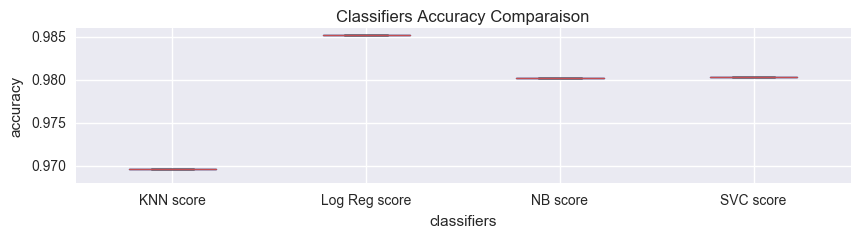

In [83]:
plt.figure(figsize=(10,2))
df_clf.boxplot()
plt.title('Classifiers Accuracy Comparaison')
plt.ylabel('accuracy')
plt.xlabel('classifiers')
plt.show()

We can see that our models are very stable and Logistic Regression classifier gives the best result. 

### Conclusion
What we can conclude seeing the result from above models is that basically Category: Sports is easier to classify than Category: Software Engineering and the performance of our classifiers is very similiar with a small advantage of LogReg. 

# Classification using LDA

In [15]:
y = df.category.values

def lda_clf(model,y):
    if model == 'logreg':
        clf = LogisticRegression()
    if model == 'svc':
        clf = SVC()    
    perf = []
    for i in [2,3,4,5,6,7,8,10,12,15,17,20,25,30]:
        doctopic = np.array(np.load("./data/doc_topic_dist_{nb}.npy".format(nb=i))).astype(float)
        X_train, X_test, y_train, y_test = train_test_split(doctopic, y, test_size=0.1, random_state=11)
        clf.fit(X_train,y_train)
        pred = clf.predict(X_test)
        perf.append(f1_score(y_test,pred))
    return perf

## Log Reg

In [101]:
perf_logreg = lda_clf('logreg',y)

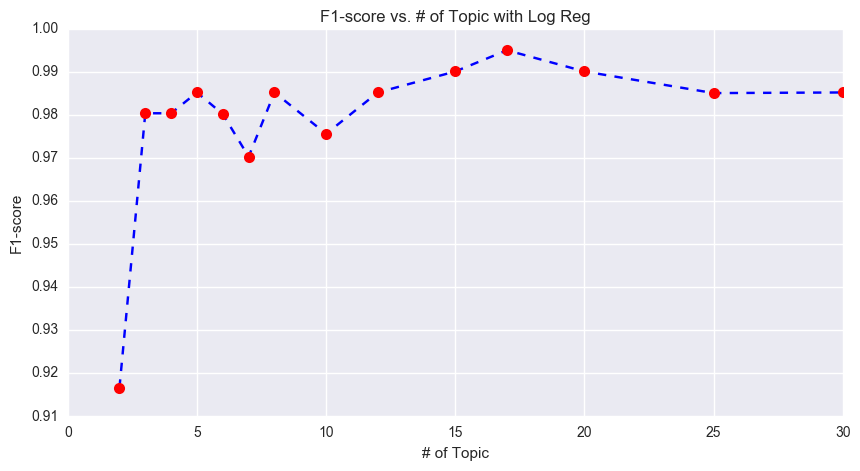

In [109]:
plt.figure(figsize=(10,5))
plt.plot([2,3,4,5,6,7,8,10,12,15,17,20,25,30],perf_logreg,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=8)
plt.title('F1-score vs. # of Topic with Log Reg')
plt.xlabel('# of Topic')
plt.ylabel('F1-score')

We can see that with 17 topics extracted from the corpus we get the best performance

### Classification result using 17 topics extracted

In [18]:
X_doctopic_17 = np.array(np.load("./data/doc_topic_dist_17.npy")).astype(float)
X_train_17, X_test_17, y_train_17, y_test_17 = train_test_split(X_doctopic_17, y, test_size=0.1, random_state=11)
log_clf_17 = LogisticRegression()
log_clf_17.fit(X_train_17,y_train_17)
pred_log_17 = log_clf_17.predict(X_test_17)

print("Confusion matrix : \n", confusion_matrix(y_test_17,pred_log_17))
print("F1-score : ", f1_score(y_test_17,pred_log_17))

Confusion matrix : 
 [[ 99   1]
 [  0 100]]
F1-score :  0.995024875622


## SVC

In [108]:
perf_svc = lda_clf('svc',y)

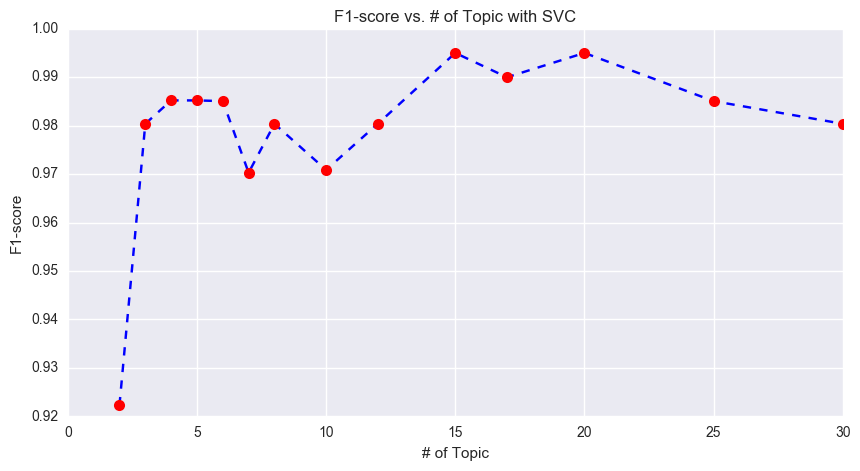

In [110]:
plt.figure(figsize=(10,5))
plt.plot([2,3,4,5,6,7,8,10,12,15,17,20,25,30],perf_svc,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=8)
plt.title('F1-score vs. # of Topic with SVC')
plt.xlabel('# of Topic')
plt.ylabel('F1-score')

This time with SVC the best performance is obtained with 15 and 20 topics extracted.

### Classification result using 15 topics extracted

In [178]:
X_doctopic_15 = np.array(np.load("./data/doc_topic_dist_15.npy")).astype(float)
X_train_15, X_test_15, y_train_15, y_test_15 = train_test_split(X_doctopic_15, y, test_size=0.1, random_state=11)
svc_clf_15 = SVC()
svc_clf_15.fit(X_train_15,y_train_15)
pred_svc_15 = svc_clf_15.predict(X_test_15)

print("Confusion matrix : \n", confusion_matrix(y_test,pred_svc_15))
print("F1-score : ", f1_score(y_test,pred_svc_15))

Confusion matrix : 
 [[ 99   1]
 [  0 100]]
F1-score :  0.995024875622


### Conclusion
We can see that the classification using LDA performs slightly better. 

## Neural Network
Now let's try to use a simple neural net to see if we can improve more.

In [36]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras import metrics
import time

Using TensorFlow backend.


In [37]:
cat = df.category
text = df.content

In [7]:
tok = Tokenizer()
tok.fit_on_texts(text)
mat_texts = tok.texts_to_matrix(text,mode='count') #build a Term-Document matrix

In [8]:
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(mat_texts, cat, test_size=0.1, random_state=11)

In [9]:
print(X_train_nn.shape,mat_texts.shape)

(1800, 68159) (2000, 68159)


In [40]:
def train_simple_model(X,y):
    model = Sequential()
    model.add(Dense(10, activation='relu', input_shape=(X.shape[1],)))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid')) #
    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc',metrics.binary_accuracy])
    print('compile done')
    model.fit(X,y,batch_size=32,verbose=1,epochs=3,validation_split=0.1)

    return model

Since it is a binary classification problem, we use the sigmoid activation function in a one-unit output layer.

In [103]:
m = train_simple_model(X_train_nn,y_train_nn)

compile done
Train on 1620 samples, validate on 180 samples
Epoch 1/3
1620/1620 [==============================] - 3s 2ms/step - loss: 0.3018 - acc: 0.9531 - binary_accuracy: 0.9531 - val_loss: 0.1548 - val_acc: 0.9833 - val_binary_accuracy: 0.9833
Epoch 2/3
1620/1620 [==============================] - 2s 1ms/step - loss: 0.0789 - acc: 0.9988 - binary_accuracy: 0.9988 - val_loss: 0.0758 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 3/3
1620/1620 [==============================] - 2s 1ms/step - loss: 0.0317 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 0.0460 - val_acc: 1.0000 - val_binary_accuracy: 1.0000


### Classification result

In [106]:
pred_nn = m.predict_classes(X_test_nn)
print("Confusion matrix : \n", confusion_matrix(y_test_nn,pred_nn))
print("F1-score : ", f1_score(y_test_nn,pred_nn))

200/200 [==============================] - 0s 596us/step
Confusion matrix : 
 [[ 97   3]
 [  0 100]]
F1-score :  0.985221674877


It would be interesting to see how the performance changes depending on the mode chosen in `texts_to_matrix()` function.   
Indeed this function provides a suite of standard bag-of-words model text encoding schemes such as:

* ‘binary‘: Check whether or not each word is present in the document.
* ‘count‘: The count of each word in the document (Term-Document matrix) 
* ‘tfidf‘: The Text Frequency-Inverse DocumentFrequency scoring for each word in the document.
* ‘freq‘: The frequency of each word as a ratio of words within each document.

In [67]:
def nn_using(scheme):
    tk = Tokenizer()
    tk.fit_on_texts(text)
    mat_txt = tk.texts_to_matrix(text,mode=scheme)
    X_tr_nn, X_te_nn, y_tr_nn, y_te_nn = train_test_split(mat_txt, cat, test_size=0.1, random_state=11)
    mod = train_simple_model(X_tr_nn,y_tr_nn)
    print('------------------------- \n')
    return mod
    

In [68]:
schemes = ['count','binary','tfidf','freq']
list_models = []
for sh in schemes:
    print('Simple Neural Net using '+ sh+ ' scheme')
    list_models.append(nn_using(sh))

Simple Neural Net using count scheme
compile done
Train on 1620 samples, validate on 180 samples
Epoch 1/3
1620/1620 [==============================] - 4s 2ms/step - loss: 0.3728 - acc: 0.8833 - binary_accuracy: 0.8833 - val_loss: 0.1699 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 2/3
1620/1620 [==============================] - 2s 1ms/step - loss: 0.0941 - acc: 0.9981 - binary_accuracy: 0.9981 - val_loss: 0.0848 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 3/3
1620/1620 [==============================] - 2s 1ms/step - loss: 0.0353 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 0.0488 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
------------------------- 

Simple Neural Net using binary scheme
compile done
Train on 1620 samples, validate on 180 samples
Epoch 1/3
1620/1620 [==============================] - 4s 2ms/step - loss: 0.3701 - acc: 0.9407 - binary_accuracy: 0.9407 - val_loss: 0.1633 - val_acc: 0.9833 - val_binary_accuracy: 0.9833
Epoch 2/3
1620/1620 [

In [69]:
df_nn_sch = pd.DataFrame(
    {'Count scheme': list_models[0].model.history.history['val_binary_accuracy'],
     'Binary scheme': list_models[1].model.history.history['val_binary_accuracy'],
     'Tfidf scheme': list_models[2].model.history.history['val_binary_accuracy'],
     'Freq scheme' : list_models[3].model.history.history['val_binary_accuracy']
    })

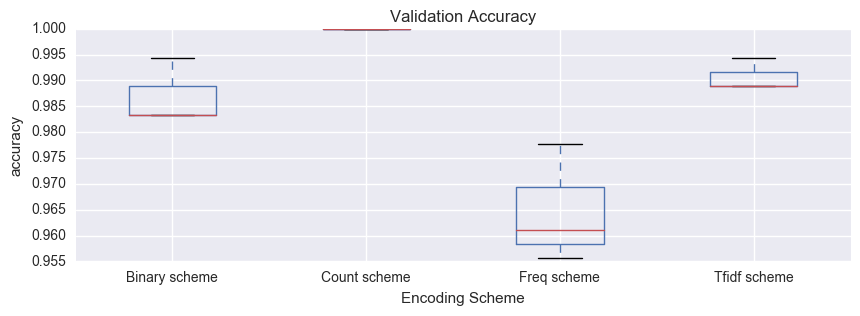

In [70]:
plt.figure(figsize=(10,3))
df_nn_sch.boxplot()
plt.title('Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Encoding Scheme')
plt.show()

We can see that the encoding scheme `count` is the most efficient but the difference with the others, except the `freq` scheme, is not very significant. 

## LSTM Recurrent Neural Network

From different sources that I could obtain, RNN is a popular option for text classification and especially the LSTM RNN which enables the neural networks to look backwards in the network and gives a memory to better understand the squential data. 

source: https://chrisalbon.com/deep-learning-keras/lstm_recurrent_neural_network.html

In [73]:
from keras.preprocessing import sequence
from keras import models
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [58]:
most_commons = 1000
tokens = Tokenizer(num_words=most_commons) # use only 1000 most commons words
tokens.fit_on_texts(text)
texts_seq = tokens.texts_to_sequences(text)
texts_mat_pad = sequence.pad_sequences(texts_seq, maxlen=400) #choose the max lenght of matrix to 40 and pad with 0 to make sure to have the same lenght
texts_mat_pad.shape

(2000, 400)

Mainly due to the lack of computation of my laptop we use only 1000 most commons words and choose the max lenght of matrix to 400. Then we pad with 0 to make sure to have the same lenght.

In [59]:
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(texts_mat_pad, cat, test_size=0.1, random_state=11)

In [77]:
def RNN(X, mostcom):
    # Start neural network
    network = models.Sequential()
    # Add an embedding layer
    network.add(layers.Embedding(input_dim=mostcom, output_dim=128))
    # Add a long short-term memory layer with 128 units
    network.add(layers.LSTM(units=128))
    # Add fully connected layer with a sigmoid activation function
    network.add(layers.Dense(units=1, activation='sigmoid'))
    # Compile neural network
    network.compile(loss='binary_crossentropy', # Cross-entropy
                    optimizer='Adam', # Adam optimization
                    metrics=['accuracy']) # Accuracy performance metric
    return network

In [113]:
def train_nn(network, X,y):
# Train neural network
    history = network.fit(X,y,epochs=10, # Number of epochs
                      verbose=1, # Do not print description after each epoch
                      batch_size=100, # Number of observations per batch
                      validation_split=0.1) # Data for evaluation
    
    return history

### Evaluate model with standardized dataset

In [82]:
k_fold = KFold(n_splits=10) 
rnn_cv = [train_nn(rnn,X_train_rnn[train], y_train_rnn[train]) for train, test in k_fold.split(X_train_rnn)]

Train on 1458 samples, validate on 162 samples
Epoch 1/3
1458/1458 [==============================] - 52s 36ms/step - loss: 0.0224 - acc: 0.9938 - val_loss: 0.0431 - val_acc: 0.9815
Epoch 2/3
1458/1458 [==============================] - 60s 41ms/step - loss: 0.0188 - acc: 0.9952 - val_loss: 0.0384 - val_acc: 0.9815
Epoch 3/3
1458/1458 [==============================] - 54s 37ms/step - loss: 0.0160 - acc: 0.9959 - val_loss: 0.0352 - val_acc: 0.9877
Train on 1458 samples, validate on 162 samples
Epoch 1/3
1458/1458 [==============================] - 56s 39ms/step - loss: 0.0110 - acc: 0.9979 - val_loss: 0.0324 - val_acc: 0.9877
Epoch 2/3
1458/1458 [==============================] - 54s 37ms/step - loss: 0.0095 - acc: 0.9979 - val_loss: 0.0312 - val_acc: 0.9877
Epoch 3/3
1458/1458 [==============================] - 52s 36ms/step - loss: 0.0082 - acc: 0.9979 - val_loss: 0.0293 - val_acc: 0.9877
Train on 1458 samples, validate on 162 samples
Epoch 1/3
1458/1458 [============================

In [112]:
lst_f1 =[]
for idx, model in enumerate(rnn_cv):
    pred = model.model.predict_classes(X_test_rnn)
    lst_f1.append(f1_score(y_test_rnn, pred))

print("Results (variance): %.2f%% (%.2f%%)" % (np.mean(lst_f1)*100, np.var(lst_f1)*100))

200/200 [==============================] - 1s 6ms/step
Results (variance): 97.03% (0.00%)


Our model is stable and doesn't seem to do some overfitting. 

### Training the neural net

In [114]:
rnn = RNN(X_train_rnn, most_commons) 
trained_net = train_nn(rnn,X_train_rnn,y_train_rnn)
trained_net

Train on 1620 samples, validate on 180 samples
Epoch 1/10
1620/1620 [==============================] - 32s 20ms/step - loss: 0.6033 - acc: 0.7500 - val_loss: 0.3028 - val_acc: 0.8667
Epoch 2/10
1620/1620 [==============================] - 34s 21ms/step - loss: 0.1682 - acc: 0.9599 - val_loss: 0.0925 - val_acc: 0.9722
Epoch 3/10
1620/1620 [==============================] - 32s 20ms/step - loss: 0.0696 - acc: 0.9864 - val_loss: 0.0481 - val_acc: 0.9889
Epoch 4/10
1620/1620 [==============================] - 33s 21ms/step - loss: 0.0447 - acc: 0.9901 - val_loss: 0.0427 - val_acc: 0.9833
Epoch 5/10
1620/1620 [==============================] - 35s 22ms/step - loss: 0.0310 - acc: 0.9926 - val_loss: 0.0543 - val_acc: 0.9833
Epoch 6/10
1620/1620 [==============================] - 35s 21ms/step - loss: 0.0225 - acc: 0.9963 - val_loss: 0.0424 - val_acc: 0.9833
Epoch 7/10
1620/1620 [==============================] - 35s 22ms/step - loss: 0.0153 - acc: 0.9981 - val_loss: 0.0215 - val_acc: 0.9944
E

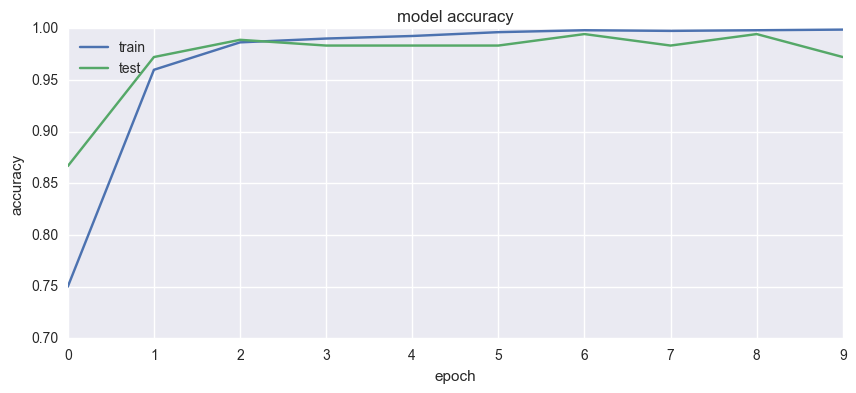

In [117]:
# summarize history for accuracy
plt.figure(figsize=(10,4))
plt.plot(trained_net.history['acc'])
plt.plot(trained_net.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Classification result

In [120]:
pred_rnn = trained_net.model.predict_classes(X_test_rnn)
print("Confusion matrix : \n", confusion_matrix(y_test_rnn,pred_rnn))
print("F1-score : ", f1_score(y_test_rnn,pred_rnn))

200/200 [==============================] - 2s 8ms/step
Confusion matrix : 
 [[91  9]
 [ 2 98]]
F1-score :  0.946859903382


### Conclusion
Surprisingly we don't get a better result than the simple neural net. One of the reasons is probably because our dataset is actually too small for LSTM to be of any advantage compared to other models (much faster) that we tested before.      

To obtain a better result we could fine-tune parameters such as the number of common words(here only 1000) or the maximum lenght (here only 400) or also the parameters directly linked with training of the neural net (hidden layer, number of epoch or the batch size).